# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 12 </span>
## <span style="color:orange"> Keras - Deep & Convolutional Neural Network image recognition </span>

## INTRODUCTION TO EXERCISE:

### MNIST with Keras

The goal of exercise 12 is to use deep neural network models, implemented in the Keras python package, to recognize and distinguish between the ten handwritten digits (0-9).

The MNIST dataset comprises $70000$ handwritten digits, each of which comes in a square image, divided into a $28\times 28$ pixel grid. Every pixel can take on $256$ gradation of the gray color, interpolating between white and black, and hence each data point assumes any value in the set $\{0,1,\dots,255\}$. Since there are $10$ categories in the problem, corresponding to the ten digits, this problem represents a generic **classification task**. 

In [39]:
#import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True' #This is needed in my Anaconda+MacOsX installation; leave it commented.
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import matplotlib.pyplot as plt
seed=0
np.random.seed(seed) # fix random seed
tf.random.set_seed(seed)

#### Step 1: Load and Process the Data

Keras can conveniently download the MNIST data from the web. All we need to do is import the `mnist` module and use the `load_data()` class, and it will create the training and test data sets or us.

The MNIST set has pre-defined test and training sets, in order to facilitate the comparison of the performance of different models on the data.

Once we have loaded the data, we need to format it in the correct shape.

In [40]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test',X_test.shape)

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)
X_test (10000, 28, 28)


#### Reshape data and convert labels to be used with categorical cross entropy
This is necessary because lable are useful for define the categories.

X_train shape: (60000, 28, 28)
Y_train shape: (60000,)
X_test (10000, 28, 28)
X_train shape: (60000, 784)
X_test shape: (10000, 784)

an example of a data point with label 1


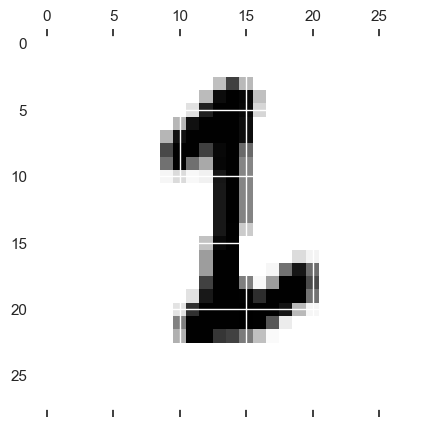

label before: categ 1
... and with label [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] after to_categorical

X_train shape: (60000, 784)
Y_train shape: (60000, 10)


In [41]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test',X_test.shape)

# reshape data, it could depend on Keras backend
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print()

# cast to floats
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# look at an example of data point
print('an example of a data point with label', Y_train[70])
# matshow: display a matrix in a new figure window  --> I have to do this thing because before I reshape the C_train
plt.matshow(X_train[70,:].reshape(28,28),cmap='binary')
plt.show()
print ("label before: categ", Y_train[70])
# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)
print('... and with label', Y_train[70], 'after to_categorical')
print()
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)

#### Step 2: Define the Neural Net and its Architecture

We can now move on to construct our deep neural net. We shall use Keras's `Sequential()` class to instantiate a model, and will add different deep layers one by one using the `add()` method

For the purposes of our example, it suffices to focus on `Dense` layers for simplicity. Every `Dense()` layer accepts as its first required argument an integer which specifies the number of neurons. The type of activation function for the layer is defined using the `activation` optional argument, the input of which is the name of the activation function in `string` format. Examples include `relu`, `tanh`, `elu`, `sigmoid`, `softmax`. 

In order for our DNN to work properly, we have to make sure that the numbers of input and output neurons for each layer match. Therefore, we specify the shape of the input in the first layer of the model explicitly using the optional argument `input_shape=(N_features,)`. The sequential construction of the model then allows Keras to infer the correct input/output dimensions of all hidden layers automatically. Hence, we only need to specify the size of the softmax output layer to match the number of categories.

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

def create_DNN():
    # instantiate model
    model = Sequential()
    # add a dense all-to-all relu layer
    model.add(Dense(400,input_shape=(img_rows*img_cols,), activation='relu'))
    # add a dense all-to-all relu layer
    model.add(Dense(100, activation='relu'))
    # apply dropout with rate 0.5
    model.add(Dropout(0.5))
    # soft-max layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model
    
print('Model architecture created successfully!')

Model architecture created successfully!


#### Step 3: Choose the Optimizer and the Cost Function

Next, we choose the loss function according to which to train the DNN. For classification problems, this is the cross entropy, and since the output data was cast in categorical form, we choose the `categorical_crossentropy` defined in Keras' `losses` module. Depending on the problem of interest one can pick any other suitable loss function. To optimize the weights of the net, we choose SGD. This algorithm is already available to use under Keras' `optimizers` module, but we could use any other built-in one as well. The parameters for the optimizer, such as `lr` (learning rate) or `momentum` are passed using the corresponding optional arguments of the `SGD()` function. All available arguments can be found in Keras' online documentation at [https://keras.io/](https://keras.io/). While the loss function and the optimizer are essential for the training procedure, to test the performance of the model one may want to look at a particular `metric` of performance. For instance, in categorical tasks one typically looks at their `accuracy`, which is defined as the percentage of correctly classified data points. To complete the definition of our model, we use the `compile()` method, with optional arguments for the `optimizer`, `loss`, and the validation `metric` as follows:

In [17]:
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam

def compile_model(optim):
    # create the model
    model=create_DNN()
    # compile the model
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=optim(),
                  metrics=['acc'])
    return model

print('Model compiled successfully and ready to be trained.')

Model compiled successfully and ready to be trained.


#### Step 4: Train the model

We train our DNN in minibatches. 

Shuffling the training data during training improves stability of the model. Thus, we train over a number of training epochs. Each epoch corresponds to using **all the train data** divided in minibatches.

Training the DNN is a one-liner using the `fit()` method of the `Sequential` class. The first two required arguments are the training input and output data. As optional arguments, we specify the mini-`batch_size`, the number of training `epochs`, and the test or `validation_data`. To monitor the training procedure for every epoch, we set `verbose=True`. 

Dropout, during training, slices off some artificial neurons, thus, training accuracy suffers.

Dropout, during testing, turns itself off and allows all of the ‘weak classifiers’ in the neural network to be used. Thus, testing accuracy improves with respect to training accuracy.

### Exercise 12.1

<span style="color:red">Change at will and train your DNN by increasing the number of epochs to an adeuqate value</span>. Try to use at least two other optimizers, different from SGD: <span style="color:red">watch to accuracy and loss for training and validation data and comment on the performances</span>.

### Resolution: 

For this result it is decided to compare four optimizers: `SGD`, `Adam`, `Adagrad`, and `Nadam`. Below are shown the comparison of `accuracy, valid accuracy, loss and valid loss` in function of number of epochs. Results are also restored  in a file called `training_results.json`. 


/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Done 0 with SGD for 5 epochs
Done 0 with SGD for 10 epochs
Done 0 with SGD for 20 epochs
Done 0 with SGD for 30 epochs
Done 0 with SGD for 40 epochs
Done 0 with SGD for 50 epochs
Done 1 with Adam for 5 epochs
Done 1 with Adam for 10 epochs
Done 1 with Adam for 20 epochs
Done 1 with Adam for 30 epochs
Done 1 with Adam for 40 epochs
Done 1 with Adam for 50 epochs
Done 2 with Adagrad for 5 epochs
Done 2 with Adagrad for 10 epochs
Done 2 with Adagrad for 20 epochs
Done 2 with Adagrad for 30 epochs
Done 2 with Adagrad for 40 epochs
Done 2 with Adagrad for 50 epochs
Done 3 with Nadam for 5 epochs
Done 3 with Nadam for 10 epochs
Done 3 with Nadam for 20 epochs
Done 3 with Nadam for 30 epochs
Done 3 with Nadam for 40 epochs
Done 3 with Nadam for 50 epochs


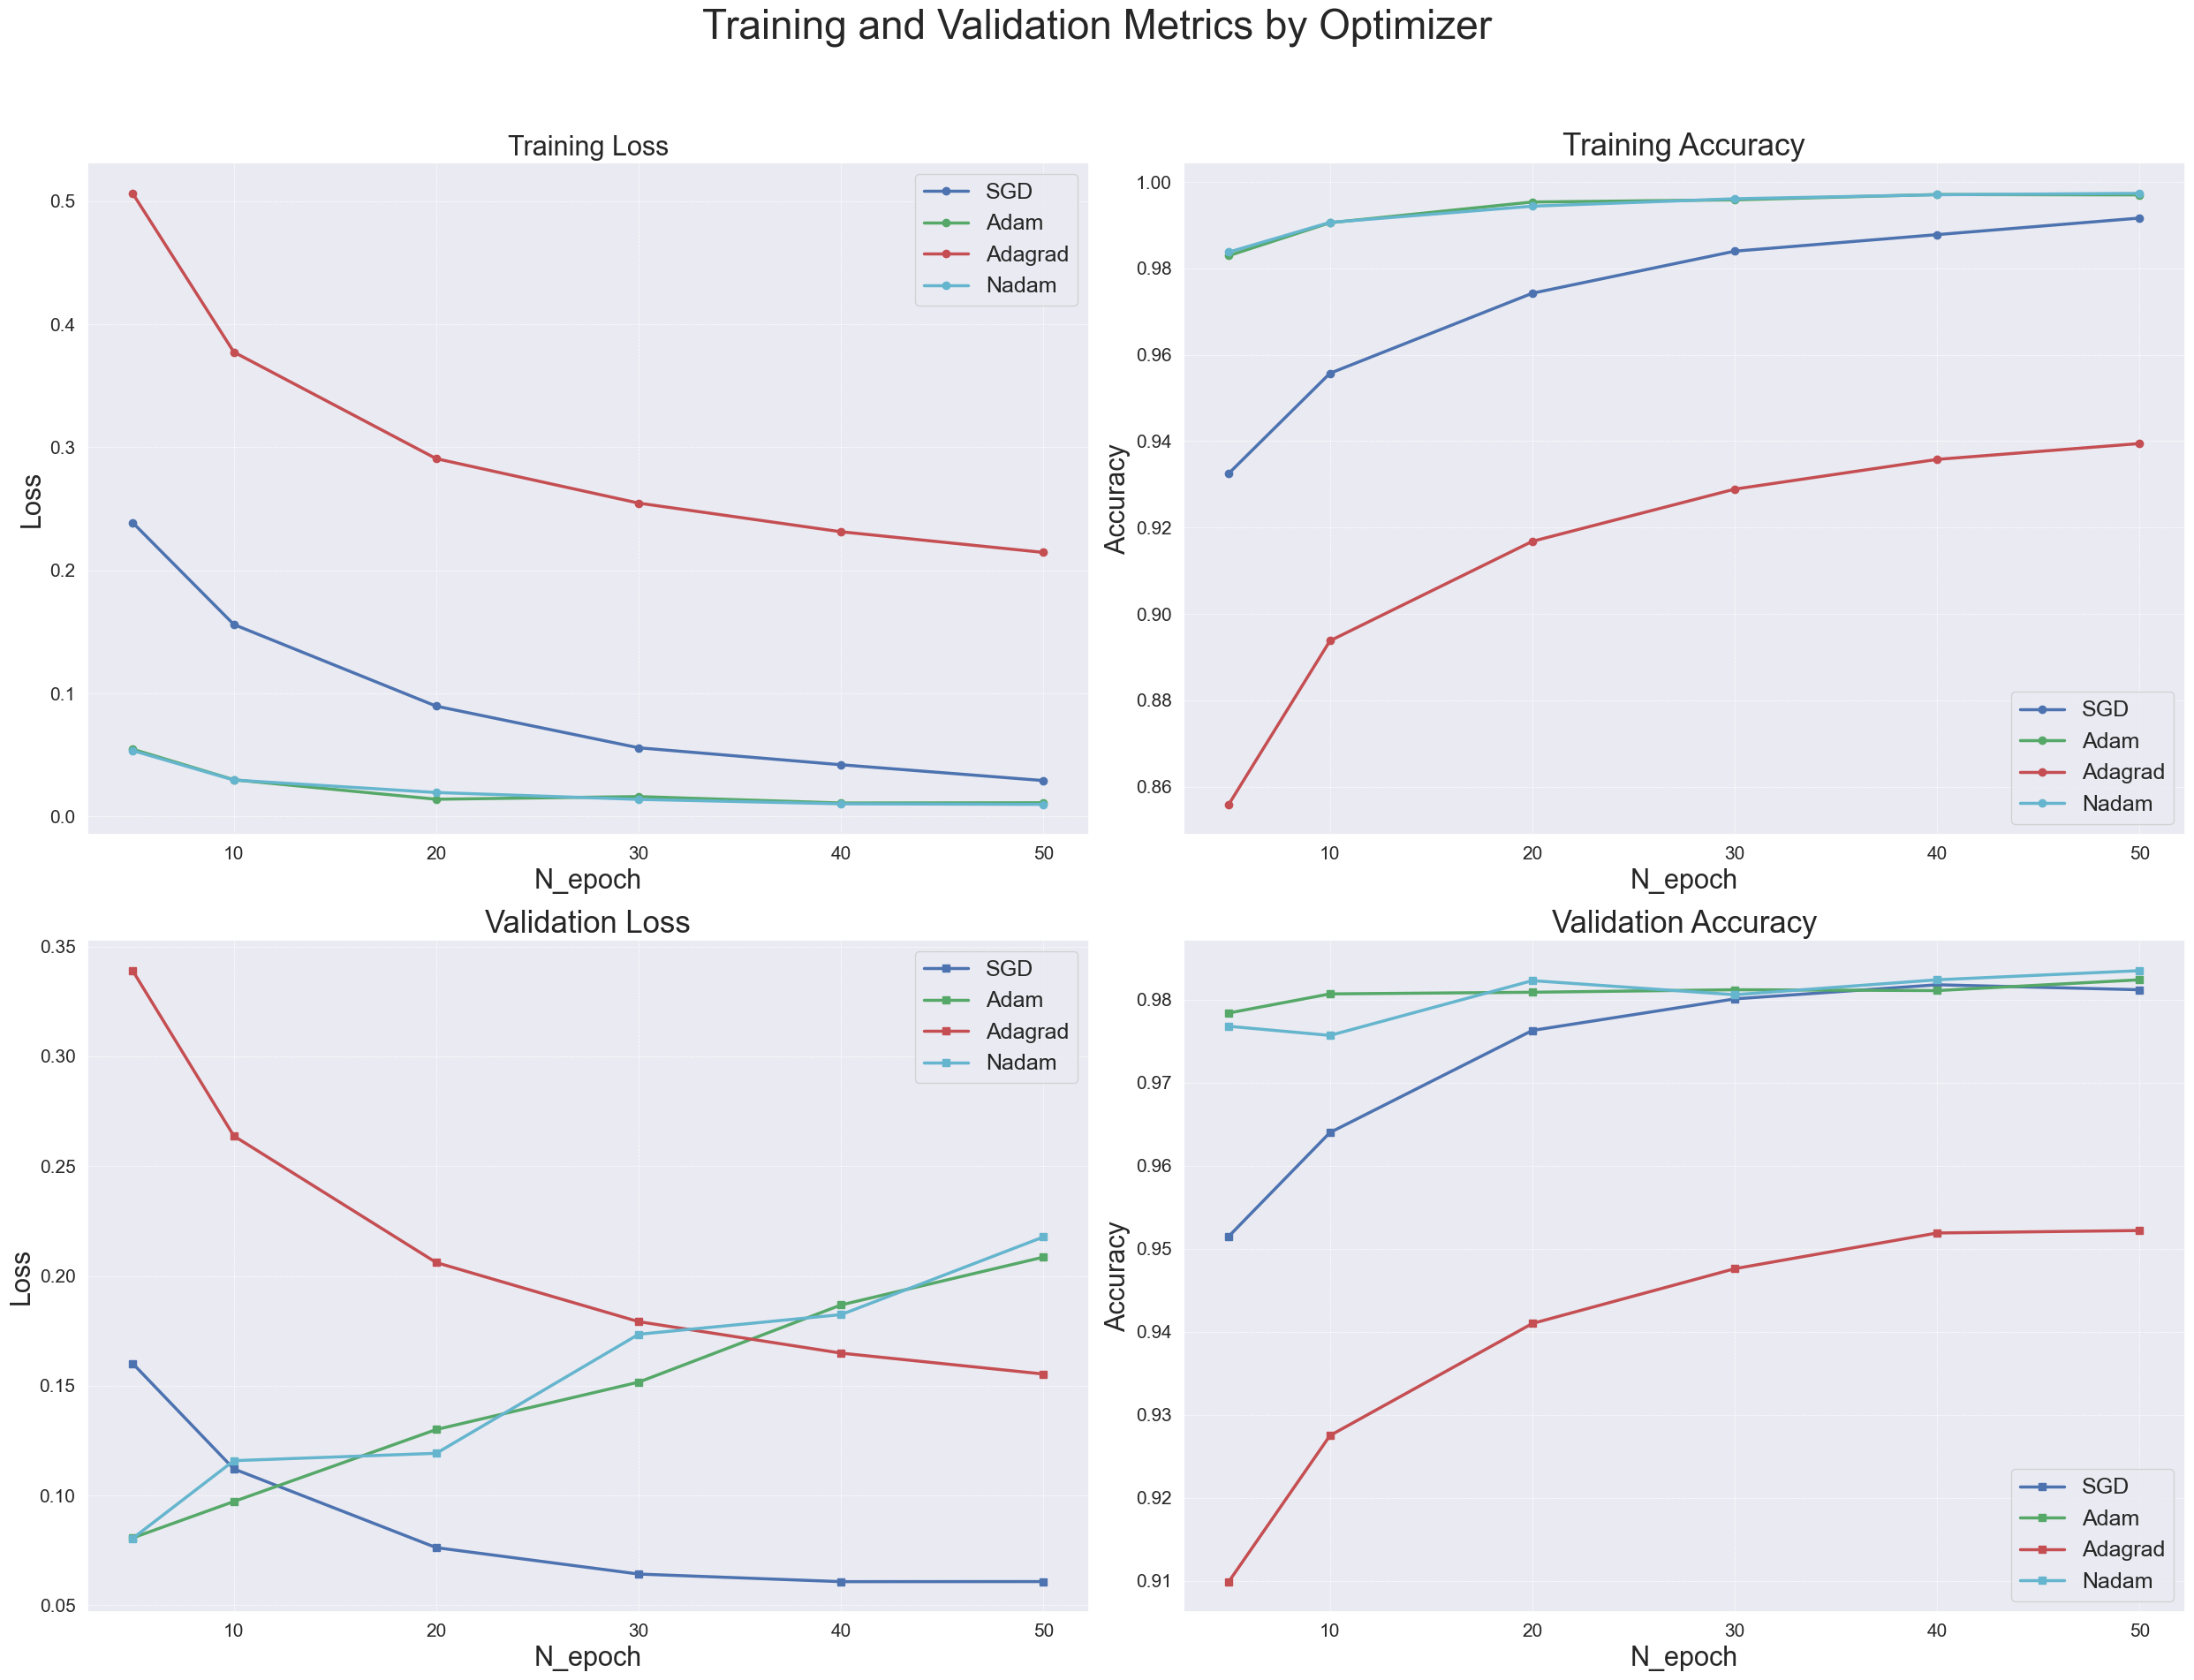

In [6]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
from keras.optimizers import SGD, Adam, Adagrad, Nadam

# Define training parameters
batch_size = 32
epoch_list = [5, 10, 20, 30, 40, 50]
optimizers = [SGD, Adam, Adagrad, Nadam]
optimizer_names = ['SGD', 'Adam', 'Adagrad', 'Nadam']
colors = ['b', 'g', 'r', 'c']  # Define a list of colors for each optimizer

# Dictionary to store results
results = {}

# Set the seaborn darkgrid style
sns.set(style="darkgrid")

# Create a figure to plot the results
fig, axs = plt.subplots(2, 2, figsize=(25, 20))
fig.suptitle('Training and Validation Metrics by Optimizer', fontsize=33)

# Loop over optimizers
for i, (optim, color) in enumerate(zip(optimizers, colors)):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    # Loop over epochs
    for epochs in epoch_list:
        # Create and compile the model with the current optimizer
        model_DNN = compile_model(optim)
        
        # Train the model and store the training info in history
        history = model_DNN.fit(X_train, Y_train,
                                batch_size=batch_size,
                                epochs=epochs,
                                verbose=0,
                                validation_data=(X_test, Y_test))

        # Collect loss and accuracy for each epoch count
        train_losses.append(history.history['loss'][-1])
        val_losses.append(history.history['val_loss'][-1])
        train_accuracies.append(history.history['acc'][-1])
        val_accuracies.append(history.history['val_acc'][-1])
        print(f"Done {i} with {optim.__name__} for {epochs} epochs")
    
    # Store results in dictionary
    results[optimizer_names[i]] = {
        'epochs': epoch_list,
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_accuracy': train_accuracies,
        'val_accuracy': val_accuracies
    }

    # Plot training loss
    axs[0, 0].plot(epoch_list, train_losses, 'o-', color=color, linewidth=2.5, label=f'{optimizer_names[i]}')
    axs[0, 0].set_title('Training Loss', fontsize=22)
    axs[0, 0].set_xlabel('N_epoch', fontsize=22)
    axs[0, 0].set_ylabel('Loss', fontsize=22)
    
    # Plot training accuracy
    axs[0, 1].plot(epoch_list, train_accuracies, 'o-', color=color, linewidth=2.5, label=f'{optimizer_names[i]}')
    axs[0, 1].set_title('Training Accuracy', fontsize=25)
    axs[0, 1].set_xlabel('N_epoch', fontsize=22)
    axs[0, 1].set_ylabel('Accuracy', fontsize=22)

    # Plot validation loss
    axs[1, 0].plot(epoch_list, val_losses, 's-', color=color, linewidth=2.5, label=f'{optimizer_names[i]}')
    axs[1, 0].set_title('Validation Loss', fontsize=25)
    axs[1, 0].set_xlabel('N_epoch', fontsize=22)
    axs[1, 0].set_ylabel('Loss', fontsize=22)
    
    # Plot validation accuracy
    axs[1, 1].plot(epoch_list, val_accuracies, 's-', color=color, linewidth=2.5, label=f'{optimizer_names[i]}')
    axs[1, 1].set_title('Validation Accuracy', fontsize=25)
    axs[1, 1].set_xlabel('N_epoch', fontsize=22)
    axs[1, 1].set_ylabel('Accuracy', fontsize=22)

# Apply dark background and grid settings for each subplot
for ax in axs.flat:
    ax.legend(fontsize=18)
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.tick_params(axis='both', which='major', labelsize=15)
    

# Save results to JSON file
with open("training_results.json", "w") as f:
    json.dump(results, f, indent=4)

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Discussion and observation:
In this chart, different optimizers are compared based on the number of epochs, specifically evaluating four optimizers: `SGD`, `Adam`, `Adagrad`, and `Nadam`. 

In the training loss plots, a clear improvement is visible for all optimizers as the number of epochs increases. Notably, the best-performing optimizers, `Adam` and `Nadam`, reach a plateau around 30 epochs, while `SGD` and `Adagrad` continue to improve. However, when examining the Validation Loss plot, it’s evident that the previously best-performing optimizers start to show signs of overfitting after about 20 epochs, as their validation loss begins to increase.

When observing the accuracy plots from training and validation, we see a consistent improvement as the epochs increase.

Based on these observations, the best choice among these optimizers is `SGD` at $N_{epoch} = 40$.


### Training and Evaluation of the best model:
Here I done the training and the evaluation of DNN with the best data find.

In [53]:
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28 # number of pixels 
# output
num_classes = 10 # 10 digits

# the data, split between train and test sets
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], img_rows*img_cols)
X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)



X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# rescale data in interval [0,1]
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices, e.g. for use with categorical_crossentropy
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)



In [54]:
# training parameters
batch_size = 32
epochs = 40
optim = SGD
# create the deep neural net
model_DNN = compile_model(optim)

# train DNN and store training info in history
history = model_DNN.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - acc: 0.6379 - loss: 1.1655 - val_acc: 0.9124 - val_loss: 0.3198
Epoch 2/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.8788 - loss: 0.4244 - val_acc: 0.9301 - val_loss: 0.2467
Epoch 3/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - acc: 0.9075 - loss: 0.3305 - val_acc: 0.9397 - val_loss: 0.2072
Epoch 4/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9206 - loss: 0.2823 - val_acc: 0.9477 - val_loss: 0.1801
Epoch 5/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - acc: 0.9298 - loss: 0.2519 - val_acc: 0.9524 - val_loss: 0.1604
Epoch 6/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - acc: 0.9388 - loss: 0.2208 - val_acc: 0.9561 - val_loss: 0.1458
Epoch 7/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - acc: 0.9439 - loss: 0.1997 - val_acc: 0.9592 - val_loss: 0.1342
Epoch 8/40
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - acc: 0.9486 - loss: 0.1835 - val_acc: 0.9613 - val_loss: 0.1257
Epoch 9/40
1875/1875 ━━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - acc: 0.9779 - loss: 0.0725

Test loss: 0.06047392636537552
Test accuracy: 0.9811999797821045


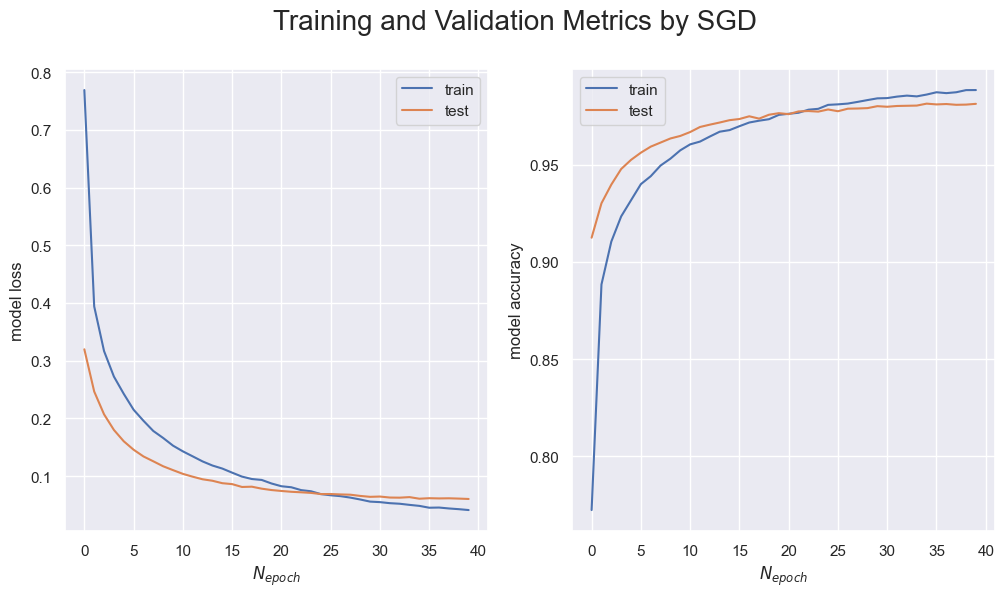

In [55]:
# evaluate model
score = model_DNN.evaluate(X_test, Y_test, verbose=1)

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Training and Validation Metrics by SGD', fontsize=20)

# look into training history
# summarize history for accuracy
axs[1].plot(history.history['acc'])
axs[1].plot(history.history['val_acc'])
axs[1].set_ylabel('model accuracy')
axs[1].set_xlabel(r'$N_{epoch}$')
axs[1].legend(['train', 'test'], loc='best')


# summarize history for loss
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].set_ylabel('model loss')
axs[0].set_xlabel(r'$N_{epoch}$')
axs[0].legend(['train', 'test'], loc='best')

plt.show()

In these plots, it is possible to observe that at 40 epochs, the validation loss is higher than the training loss. However, this is not an issue of overfitting because the validation loss is still decreasing. Regarding the accuracy curve, the validation accuracy reaches 98%, which can be considered good.

### Prediction:

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step


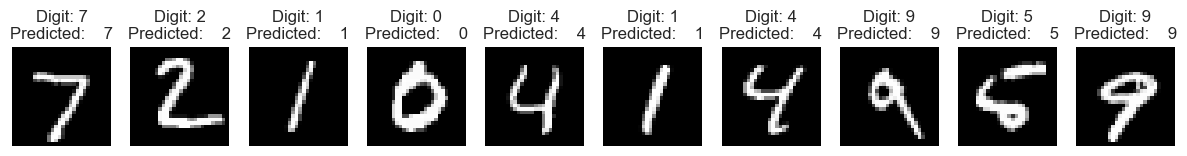

In [51]:
#X_test = X_test.reshape(X_test.shape[0], img_rows*img_cols)
predictions = model_DNN.predict(X_test)

X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols,1)

plt.figure(figsize=(15, 15)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(X_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit: {}\nPredicted:    {}".format(np.argmax(Y_test[i]), np.argmax(predictions[i])))    
    plt.axis('off') 
plt.show()

### Discussion and Observation:

In this exercise, we explored how to construct a deep neural network (DNN) for recognizing numbers from 0 to 9. The predictions show that the network can perform this task to some extent. However, a DNN is not fully optimized for image recognition, as it is a fully connected network and does not inherently handle spatial information. 

In contrast, convolutional neural networks (CNNs) are designed to learn and capture spatial features more effectively, making them better suited for image-related tasks. This difference will be explored in the next exercise, where CNNs are used to enhance spatial feature learning in images.

